In [2]:
import os
import glob
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchmetrics.functional import char_error_rate

from PIL import Image

from tqdm.notebook import tqdm

import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

### 1. Подготовка данных

In [3]:
class ImgDataset(Dataset):
    def __init__(self, source_dir='data'):
        super().__init__()
        
        self.source_dir = source_dir
        self._image_paths = list(glob.glob(os.path.join(self.source_dir, '*')))
        
        self._char_to_id = {}
        self._id_to_char = {}
        self._check_possible_chars()
    
    def __len__(self):
        return len(self._image_paths)
    
    def __getitem__(self, idx: int):
        image_path = self._image_paths[idx]
        
        image = Image.open(image_path)
        image = torch.from_numpy(
            np.array(
                image.convert('L')
            ).astype(np.float32)
        ).unsqueeze(0)
        
        label = [self._char_to_id[x] for x in ImgDataset._get_clear_name(image_path)]
        label = torch.LongTensor(label)
        
        return image, label
    
    def get_image_by_label(self, label):
        image_path = [x for x in self._image_paths if f'{os.path.sep}{label}.' in x][0]
        image = Image.open(image_path)
        return image
    
    @staticmethod
    def _get_clear_name(path):
        _, file_name = os.path.split(path)
        return file_name.split('.')[0]
        
    def _check_possible_chars(self):
        char_id = 1
        for image_path in self._image_paths:
            for char in ImgDataset._get_clear_name(image_path):
                if char not in self._char_to_id:
                    self._char_to_id[char] = char_id
                    char_id += 1
        
        self._id_to_char = {id: char for char, id in self._char_to_id.items()}

In [5]:
dataset = ImgDataset(source_dir='../data')

# из описания лабораторной работы, делим 4 к 1
train_size = (len(dataset) // 5) * 4
test_size = len(dataset) - train_size
print(f'train_size={train_size} test_size={test_size}')

train_set, test_set = random_split(
    dataset,
    (train_size, test_size),
    generator=torch.Generator().manual_seed(42)
)

BATCH_SIZE = 10
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

train_size=856 test_size=214


### 2. Создание и обучение модели

Первичные эксперименты в виде "сделать модель своими руками с нуля" показали скромные результаты. В итоге нашёл исходную (видимо) статью, изображение из которой использовалось в описании домашнего задания. Воспользуемся архитектурой предложенной в этой статье: https://arxiv.org/pdf/1507.05717v1.pdf

In [4]:
class CRNN(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()

        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=1, padding=0)
        )
        
        self.rnn_layer_1 = nn.LSTM(1024, 256, bidirectional=True)
        self.rnn_layer_2 = nn.LSTM(512, 256, bidirectional=True)
        
        self.linear_layer = nn.Linear(512, num_classes)
        
    def forward(self, img_batch):
        x = self.cnn_layers(img_batch)
        
        batch_size, *x_size = x.size()
        x = x.reshape(batch_size, x_size[0] * x_size[1], x_size[2]).permute(2, 0, 1)
        
        x, hidden_state = self.rnn_layer_1(x)
        x, hidden_state = self.rnn_layer_2(x)
        
        return self.linear_layer(x)

Функция для обучения модели

In [5]:
def train_model(device, train_loader, test_loader, model, optimizer, criterion, num_epochs):
    train_loss = []
    test_loss = []

    for epoch in tqdm(range(num_epochs)):
        
        temp_loss = []
        model.train()
        for batch in train_loader:
            images, labels = [x.to(device) for x in batch]
            labels_len = torch.LongTensor([[5] * len(labels)])
            
            output = model(images)
            output_size = output.size()
            output_labels_len = torch.LongTensor([output_size[0]] * output_size[1])
            
            log_probas = F.log_softmax(output, dim=2)
            loss = criterion(log_probas, labels, output_labels_len, labels_len)

            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()
            
            temp_loss.append(loss.item())
        train_loss.append({'epoch': epoch, 'loss': np.mean(temp_loss)})
        
        temp_loss = []
        model.eval()
        with torch.no_grad():
            for batch in test_loader:
                images, labels = [x.to(device) for x in batch]
                labels_len = torch.LongTensor([[5] * len(labels)])

                output = model(images)
                output_size = output.size()
                output_labels_len = torch.LongTensor([output_size[0]] * output_size[1])
                
                log_probas = F.log_softmax(output, dim=2)
                loss = criterion(log_probas, labels, output_labels_len, labels_len)

                temp_loss.append(loss.item())
        test_loss.append({'epoch': epoch, 'loss': np.mean(temp_loss)})
        
    train_history = pd.DataFrame(data=train_loss)
    train_history['source'] = 'train'
    test_history = pd.DataFrame(data=test_loss)
    test_history['source'] = 'test'
    
    loss_history = pd.DataFrame()
    loss_history = loss_history.append(train_history, ignore_index=True)
    loss_history = loss_history.append(test_history, ignore_index=True)

    return loss_history

Графики + средняя ошибка для последних 10 эпох при обучении

In [6]:
def plot_loss_history(loss_history, learning_rate):
    max_epoch = loss_history.epoch.max()
    train_mean_loss = np.mean(loss_history[((loss_history["epoch"] > max_epoch - 10)
                                        & (loss_history["source"] == "train"))].loss)

    test_mean_loss = np.mean(loss_history[((loss_history["epoch"] > max_epoch - 10)
                                        & (loss_history["source"] == "test"))].loss)
    print(f'Avg of last 10 epoch loss. Train: {train_mean_loss}. Test: {test_mean_loss}')

    sns.set(rc={'figure.figsize':(16., 8.27)})
    b = sns.lineplot(data=loss_history, x='epoch', y='loss', hue='source', linewidth = 1.5)

    b.axes.set_title(f'LR={learning_rate}. CTCLoss on train and test')
    b.set_xlabel("Epoch")
    b.set_ylabel("Loss")

    plt.legend(title='Source')
    plt.show()

    epoch_border = 40
    b = sns.lineplot(data=loss_history[loss_history.epoch >= epoch_border],
                     x='epoch', y='loss', hue='source', linewidth = 1.5)

    b.axes.set_title(f'LR={learning_rate}. CTCLoss on train and test for epoch >= {epoch_border}')
    b.set_xlabel("Epoch")
    b.set_ylabel("Loss")

    plt.legend(title='Source')
    plt.show()

In [7]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

Забегая вперед, нужно сказать что с данной архитектурой сети было получено хорошее (CER < 1%) качество распознавания. Ввиду этого, поиска альтернативной архитектуры не выполнялось. Оставил часть экспериментов по выбору learning rate. Было попробовано дефолтное значение для оптимизатора (Adam, lr=0.001) и ещё два меньших значения (на порядок и на два порядка).<br />
<br />
Так же необходимо отметить, что осознанно при обучении для валидации использовалась тестовая выборка, так как данных для обучения и без того кажется что мало (856 картинок) и дополнительно дробить обучающий набор нехотелось. Так же, как мы увидим из результатов, данный ход не влиял на выбор гиперпараметров, следовательно ничего криминального в этом быть не должно.

#### LR = 0.001

  0%|          | 0/75 [00:00<?, ?it/s]

Avg of last 10 epoch loss. Train: 0.06922806339111007. Test: 0.41789964058817447


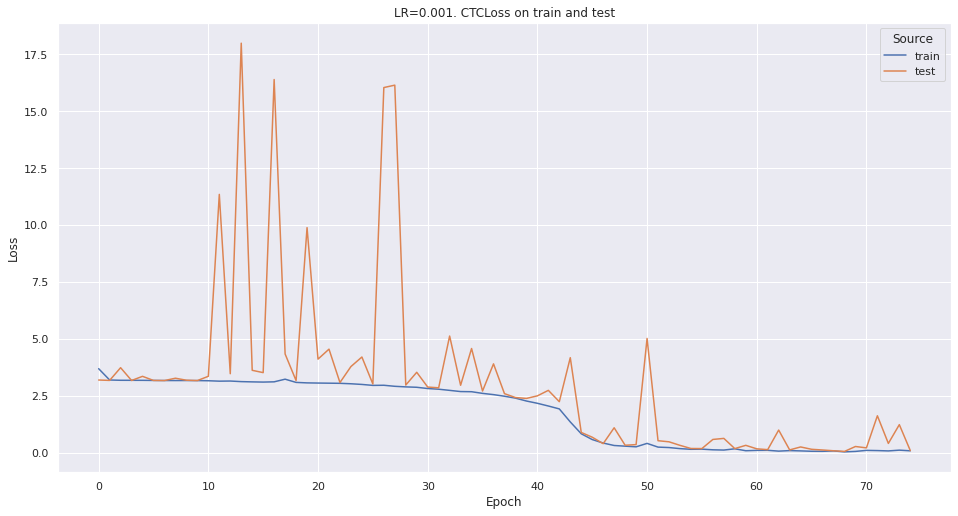

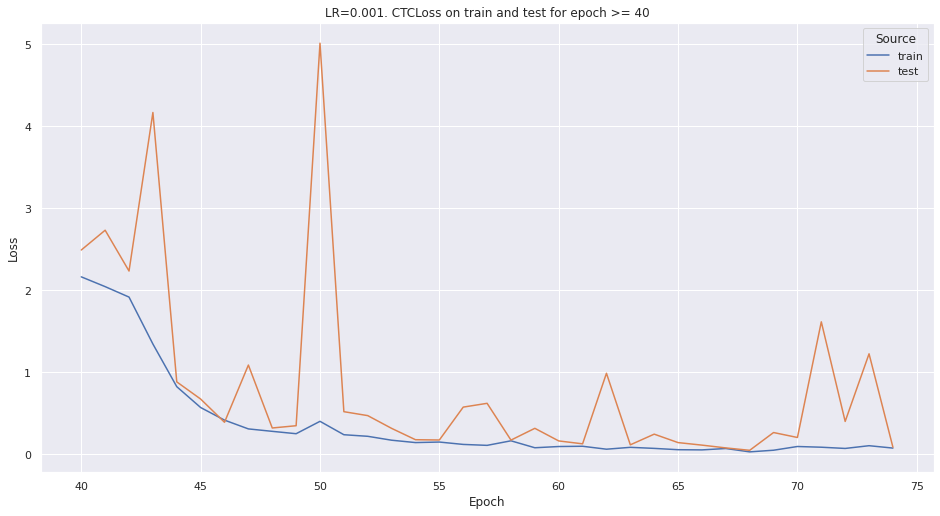

In [15]:
# добавим дополнительный "класс" для возможности сети определять "символы" которых не было на картинках
crnn = CRNN(in_channels=1, num_classes=1 + len(dataset._char_to_id))
crnn.to(device)

learning_rate_1 = 0.001
optimizer = torch.optim.Adam(crnn.parameters(), lr=learning_rate_1)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)


loss_history_1 = train_model(
    device,
    train_loader=train_loader,
    test_loader=test_loader,
    model=crnn,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=75
)

plot_loss_history(loss_history_1, learning_rate_1)

#### LR = 0.00001

  0%|          | 0/75 [00:00<?, ?it/s]

Avg of last 10 epoch loss. Train: 0.7824645997479904. Test: 1.4752098121426322


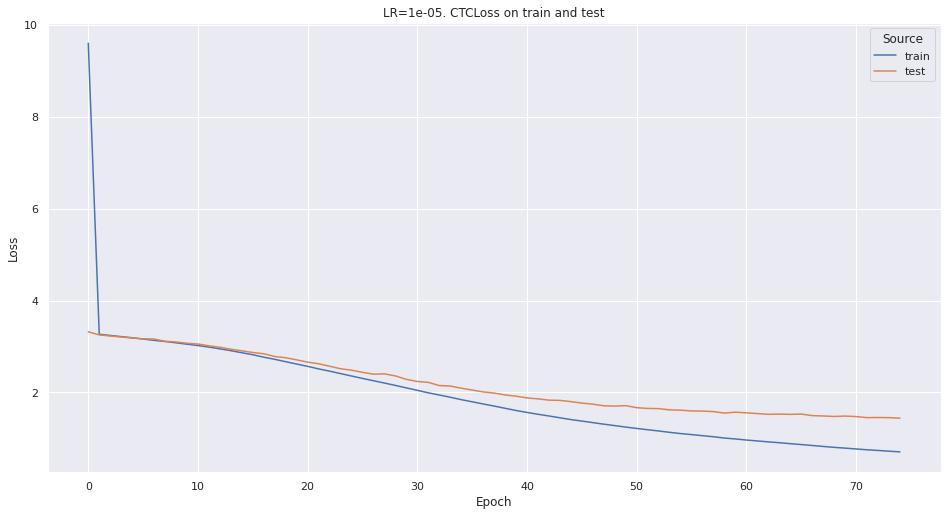

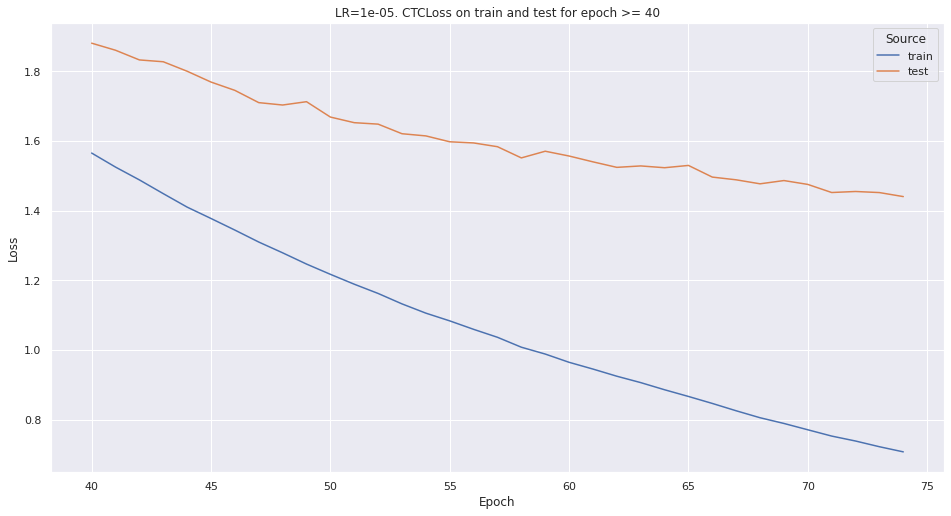

In [16]:
crnn = CRNN(in_channels=1, num_classes=1 + len(dataset._char_to_id))
crnn.to(device)

learning_rate_2 = 0.00001
optimizer = torch.optim.Adam(crnn.parameters(), lr=learning_rate_2)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)


loss_history_2 = train_model(
    device,
    train_loader=train_loader,
    test_loader=test_loader,
    model=crnn,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=75
)

plot_loss_history(loss_history_2, learning_rate_2)

#### LR = 0.0001

  0%|          | 0/75 [00:00<?, ?it/s]

Avg of last 10 epoch loss. Train: 0.0007897738017396308. Test: 0.017886261532972146


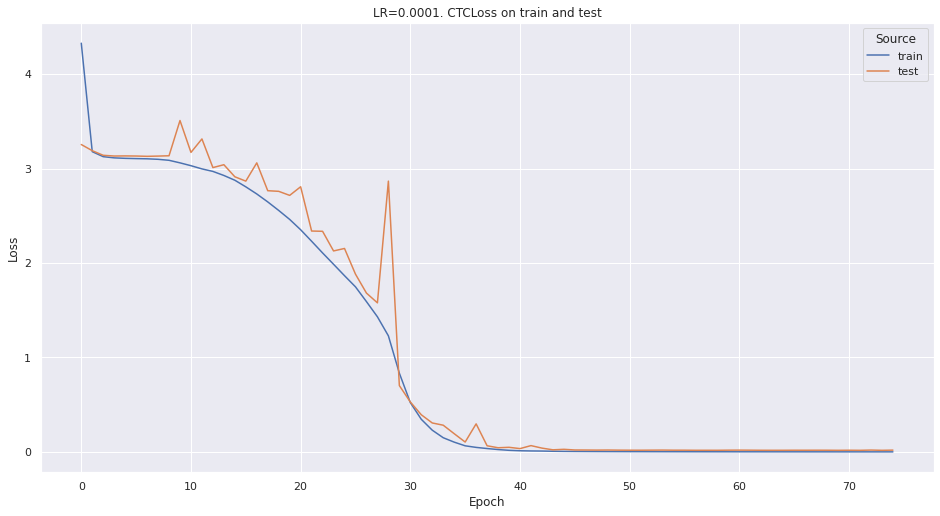

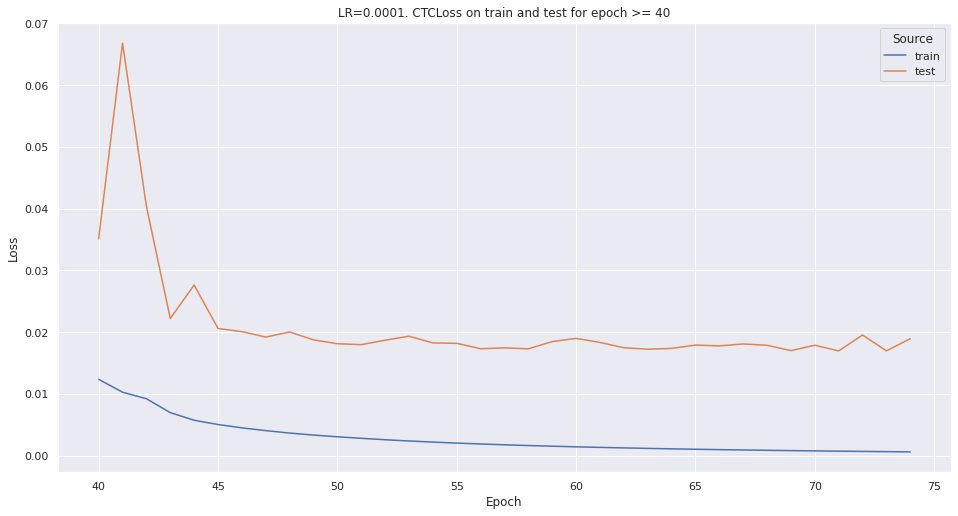

In [20]:
crnn = CRNN(in_channels=1, num_classes=1 + len(dataset._char_to_id))
crnn.to(device)

learning_rate_3 = 0.0001
optimizer = torch.optim.Adam(crnn.parameters(), lr=learning_rate_3)
criterion = nn.CTCLoss(zero_infinity=True)
criterion.to(device)


loss_history_3 = train_model(
    device,
    train_loader=train_loader,
    test_loader=test_loader,
    model=crnn,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=75
)

plot_loss_history(loss_history_3, learning_rate_3)

Видно, что при learning_rate=0.0001 мы получаем наименьшую ошибку как на трейне так и на тесте.
Так же из последнего графика видно, что ощутимого переобучения мы не получаем для данного lr и количества эпох. Так что предлагаю остановиться на последней версии обученной сети и посмотреть какое значение метрики мы получим на тестовой выборке.

### 3. Подсчет метрик

In [33]:
real = []
predictions = []

crnn.eval()
with torch.no_grad():
    for batch in test_loader:
        images, labels = [x.to(device) for x in batch]
        labels_len = torch.LongTensor([[5] * len(labels)])

        output = crnn(images)
        output_size = output.size()
        output_labels_len = torch.LongTensor([output_size[0]] * output_size[1])

        log_probas = F.log_softmax(output, dim=2).permute((1, 0, 2))
        
        for i in range(len(labels)):
            prediction = torch.unique_consecutive(
                torch.argmax(log_probas[i], axis=1)
            )
            predicted_label = ''.join(dataset._id_to_char.get(x.item(), '') for x in prediction)
            predictions.append(predicted_label)
            
            real_label = ''.join(dataset._id_to_char.get(x.item(), '') for x in labels[i])
            real.append(real_label)
            
print(f'CER on Test: {char_error_rate(predictions, real)}')

CER on Test: 0.004672897048294544


#### Таким образом, на тесте получено значение CER < 1%, что достаточно хорошо, если ориентироваться на дискорд

### 4. Анализ ошибок модели

In [64]:
test_results = pd.DataFrame()
test_results['real'] = real
test_results['prediction'] = predictions
test_results

,real,prediction
0,pgg3n,pgg3n
1,5n3w4,5n3w4
2,4gb3f,4gb3f
3,g8gnd,g8gnd
4,33n73,33n73
...,...,...
209,e6b7y,e6b7y
210,36w25,36w25
211,8gmc4,8gmc4
212,cgcgb,cgcgb


In [75]:
test_errors = test_results[test_results.real != test_results.prediction][:]
test_errors['CER'] = test_errors.apply(lambda row: char_error_rate(row['prediction'], row['real']).item(), axis=1)
test_errors = test_errors.sort_values(by=['CER'], ascending=False).reset_index(drop=True)
test_errors

,real,prediction,CER
0,bwmee,bwne,0.4
1,edwny,edwmy,0.2
2,gwn53,gwn3,0.2
3,cwmny,cwmmy,0.2


На тестовой выборке, получили 4 неправильных распознавания (из 214). Отобразим их и посмотрим подробнее.

1. CER=0.4000000059604645. Real label:"bwmee". Predicted label:"bwne"


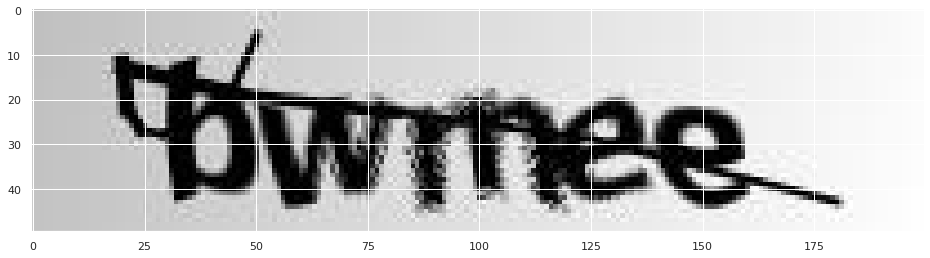

2. CER=0.20000000298023224. Real label:"edwny". Predicted label:"edwmy"


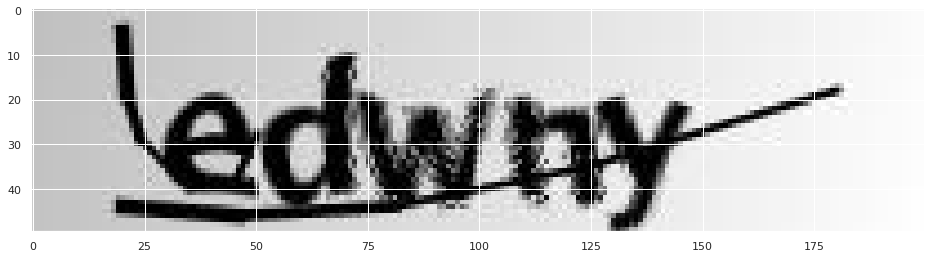

3. CER=0.20000000298023224. Real label:"gwn53". Predicted label:"gwn3"


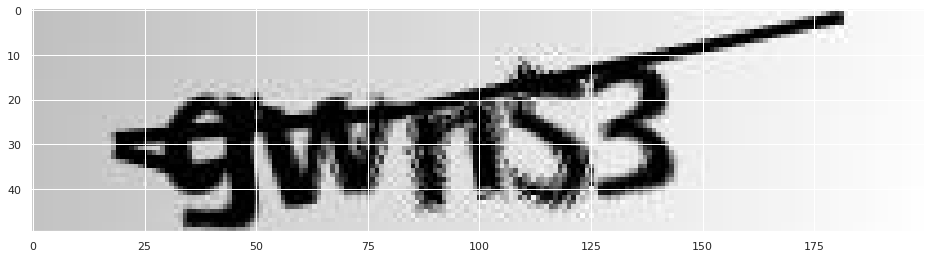

4. CER=0.20000000298023224. Real label:"cwmny". Predicted label:"cwmmy"


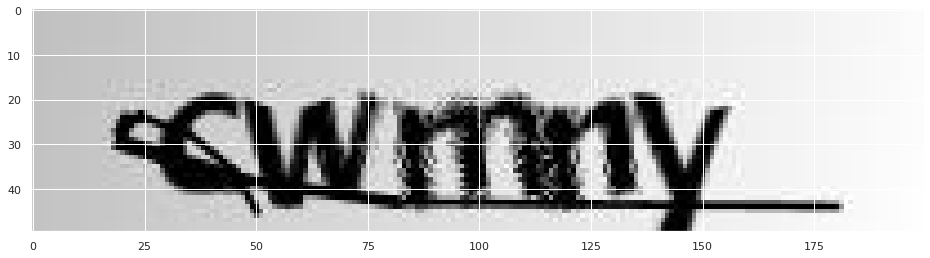

In [77]:
for i in range(len(test_errors)):
    error = test_errors.iloc[i]
    
    print(f'{i+1}. CER={error["CER"]}. Real label:"{error["real"]}". Predicted label:"{error["prediction"]}"')
    
    image = dataset.get_image_by_label(error['real'])
    plt.imshow(image)
    plt.show()

Честно сказать, крайне сложно пытаться выделить какие то общие паттерны в ошибках, когда их всего 4. И тем более пытаться придумать возможное изменение чтобы их избежать. Тем не менее видим, что в случае 1, 2 и 4 модель перепутала m и n. Посмотрим на примеры картинок с m и n, которые модель правильно распознала

In [105]:
np.array(list(set(test_results[test_results.real.str.contains('m')].real.unique()) - set(test_errors.real)))

array(['2x7bm', 'bp6mw', 'mggce', '43mn5', 'excmn', 'mnef5', '6mege',
       '7w67m', 'pm47f', 'c86md', '46mbm', '5325m', '8gmc4', 'n4b4m',
       'x6b5m', '7bwm2', 'pym7p', 'cewnm', 'n3bm6', 'm457d', '65m85',
       'gw53m', 'mb4en', '56m6y', 'bn5mw', 'pgmn2', 'mdyp7', 'xymfn',
       'pmd3w', '3n7mx', 'gm6nn', 'pcmcc', 'w4x2m', 'mpxfb', 'pmf5w',
       'nxcmn', 'y33nm', '6dmx7', '6mygb', '58b5m', 'pcm7f', 'p2ym2',
       'dgcm4', '5dxnm', '3dgmf', '5mfff', 'y7mnm', '6gnm3', 'bw5ym',
       'pnmxf', 'm22e3', '25p2m', 'mbf58', 'ng46m', 'nbf8m', 'm5meg',
       'mdxpn'], dtype='<U5')

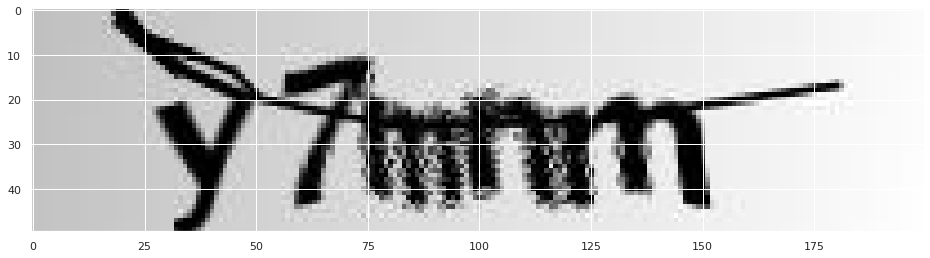

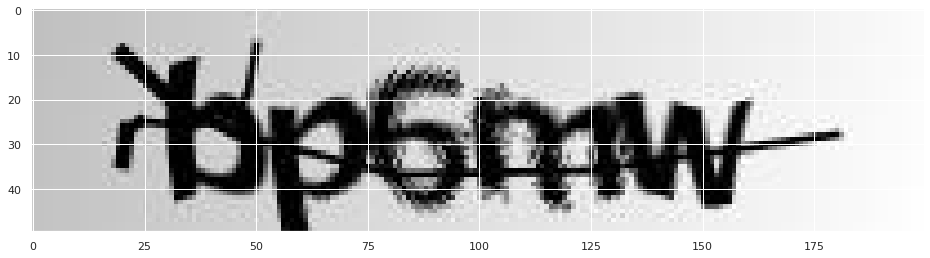

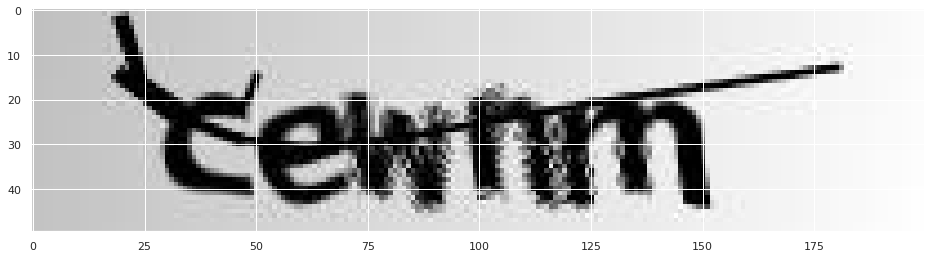

In [106]:
plt.imshow(dataset.get_image_by_label('y7mnm'))
plt.show()
plt.imshow(dataset.get_image_by_label('bp6mw'))
plt.show()
plt.imshow(dataset.get_image_by_label('cewnm'))
plt.show()

Специально отобразил картинки, похожие своими особенностями на те, на которых модель ошиблась (m или n "наезжает" собой на соседнии символы). Учитывая что правильно распозналось большое количество картинок, кажется что в целом модель хорошо работает на подобных примерах. Казалось бы, чтобы решить возможную проблему "наезжания" букв друг на друга, нам необходимо увеличивать рецептивное поле (увеличивая размер ядра сверток или увеличивая глубину сети). Но кажется у нас сеть уже достаточно глубокая. Возможно помогло бы большое (и более вариативное) количество примеров или аугментация изображений при обучении.

В 3-м примере проблема с перечеркнутой на шляпке пятеркой. Посмотрим уданые распознавания

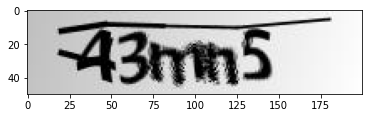

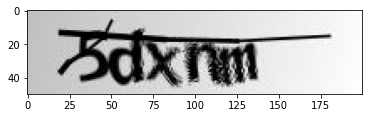

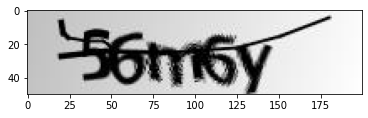

In [12]:
plt.imshow(dataset.get_image_by_label('43mn5'))
plt.show()
plt.imshow(dataset.get_image_by_label('5dxnm'))
plt.show()
plt.imshow(dataset.get_image_by_label('56m6y'))
plt.show()

В целом, есть картиноки с похожей "проблемой" (перечекнутая "шляпка"). Может нам просто не повезло конкретно с этой?)

Повторюсь ещё раз, сложно делать предположения опираясь на 4 ошибки распознавания.
Возможно такой навык появляется с опытом :)